# EDA

## Import and Connect to Database

In [9]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

import torch
from torchvision import models, transforms
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [18]:
x = torch.rand(5, 3)
print(x)

tensor([[0.1612, 0.7316, 0.6636],
        [0.0054, 0.9670, 0.4912],
        [0.9205, 0.3622, 0.4672],
        [0.1089, 0.9372, 0.7831],
        [0.7666, 0.4331, 0.3225]])


In [10]:
db_path = "../data/chinese_dataset/chinese_characters.db"

In [11]:
conn = sqlite3.connect(db_path)
query = "SELECT * FROM characters"
df = pd.read_sql_query(query, conn)
conn.close()

In [12]:
# Display the first few rows of the dataset
df.head()

,character,meaning
0,一,"one; all, whole, throughout; radical; uniform,..."
1,丁,T-shaped; fourth
2,丂,"bough, branch of tree used as a walking stick ..."
3,七,seven
4,万,musicians (arch.); ten thousand


### Image Data

In [ ]:
images_dir = "../data/chinese_dataset/images"

In [12]:
# Step 1: Read filenames
filenames = [
    f for f in os.listdir(images_dir) 
    if os.path.isfile(os.path.join(images_dir, f)) and "_" in f
]

# Step 2: Extract font names from filenames
font_names = [name.split("_")[1].replace(".png", "") for name in filenames if "Error" not in name]

# Step 3: Count occurrences of each font
font_counts = Counter(font_names)

# Step 4: Save data to SQLite database
# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Create the table if it doesn't exist
cursor.execute("""
CREATE TABLE IF NOT EXISTS font_statistics (
    font_name TEXT PRIMARY KEY,
    count INTEGER
)
""")

# Insert or update data in the table
for font_name, count in font_counts.items():
    cursor.execute("""
    INSERT INTO font_statistics (font_name, count)
    VALUES (?, ?)
    ON CONFLICT(font_name) DO UPDATE SET count = excluded.count
    """, (font_name, count))

# Commit changes and close the connection
conn.commit()
conn.close()

print(f"Font statistics saved to {db_path}")

     Font Name  Count
0  NotoSerifJP   7668
1  NotoSerifTC      2
Font statistics saved to ../data/chinese_dataset/chinese_characters.db


## Display Dataset

General information about the dataset

In [7]:
print("Dataset Information:")
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8751 entries, 0 to 8750
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   character  8751 non-null   object
 1   meaning    8751 non-null   object
dtypes: object(2)
memory usage: 136.9+ KB


In [13]:
print("\nSummary Statistics:")
df.describe()


Summary Statistics:


,character,meaning
count,8751,8751
unique,8751,8382
top,一,surname
freq,1,13


In [9]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
character    0
meaning      0
dtype: int64


## Display Data

### Image Quality Check

In [13]:

# Define a directory containing images
images_dir = "../data/chinese_dataset/images"

# Helper function to display a grid of images
def display_images(image_paths, cols=5, figsize=(15, 10)):
    plt.figure(figsize=figsize)
    for i, image_path in enumerate(image_paths):
        img = Image.open(image_path)
        plt.subplot(len(image_paths) // cols + 1, cols, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(os.path.basename(image_path))
    plt.show()

C:\Users\ng_ro\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ng_ro\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 19969 (\N{CJK UNIFIED IDEOGRAPH-4E01}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ng_ro\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 19970 (\N{CJK UNIFIED IDEOGRAPH-4E02}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ng_ro\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 19971 (\N{CJK UNIFIED IDEOGRAPH-4E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ng_ro\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py

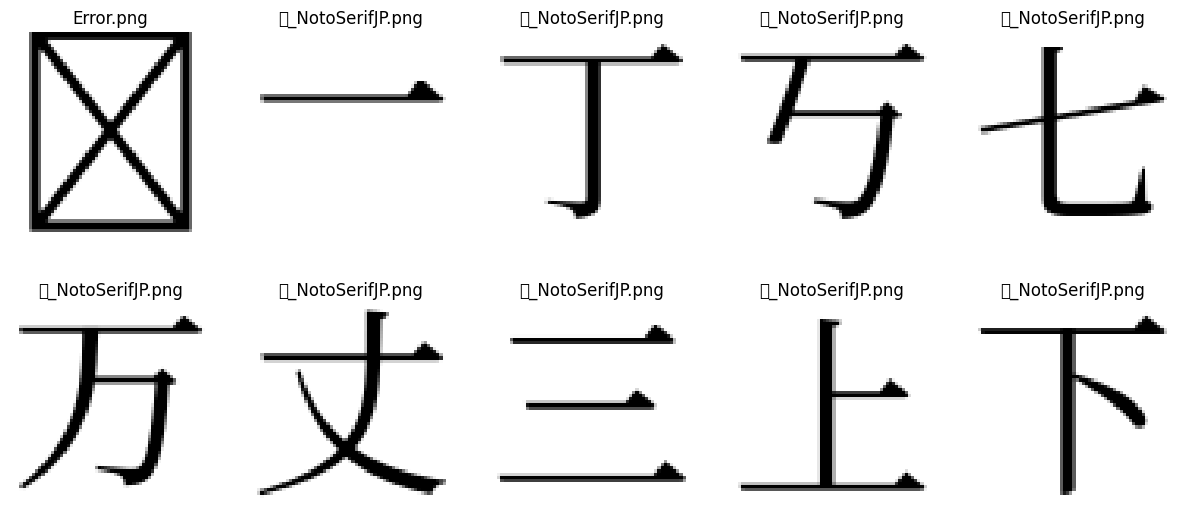

In [14]:
# Select a random sample of image paths
image_files = [os.path.join(images_dir, img) for img in os.listdir(images_dir) if img.endswith('.png')]
sample_images = image_files[:10]  # Adjust sample size
display_images(sample_images)


### Character Coverage

Number of characters covered: 8751
Number of missing characters: 12241


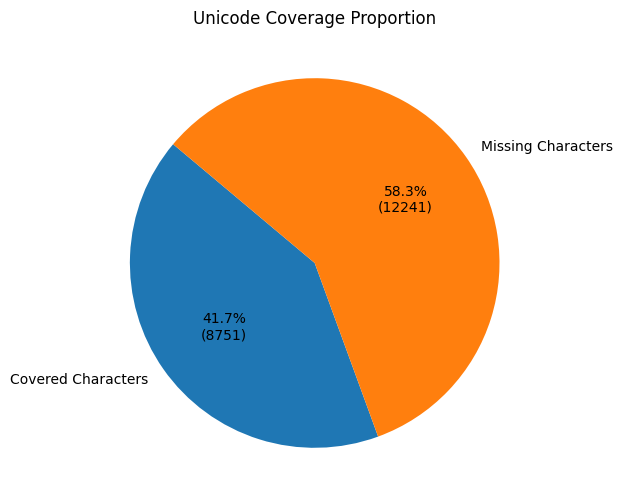

In [15]:
# Define the Unicode range for Chinese characters
unicode_range = range(0x4E00, 0x9FFF + 1)

# Convert character column to Unicode code points
characters_covered = set(ord(ch) for ch in df['character'])

# Calculate missing characters
missing_characters = set(unicode_range) - characters_covered

# Coverage stats
num_covered = len(characters_covered)
num_missing = len(missing_characters)
total_characters = len(unicode_range)

print(f"Number of characters covered: {num_covered}")
print(f"Number of missing characters: {num_missing}")

# Data for visualization
coverage_data = [num_covered, num_missing]
labels = ['Covered Characters', 'Missing Characters']

# Pie Chart with counts and percentages
def autopct_with_counts(pct, all_vals):
    total = sum(all_vals)
    count = int(round(pct * total / 100.0))
    return f"{pct:.1f}%\n({count})"

plt.figure(figsize=(8, 6))
plt.pie(
    coverage_data, 
    labels=labels, 
    autopct=lambda pct: autopct_with_counts(pct, coverage_data), 
    startangle=140
)
plt.title("Unicode Coverage Proportion")
plt.show()

## Image visualize  

In [16]:
# Path to images
image_dir = "../data/chinese_dataset/images"

C:\Users\ng_ro\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ng_ro\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\ng_ro\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by set

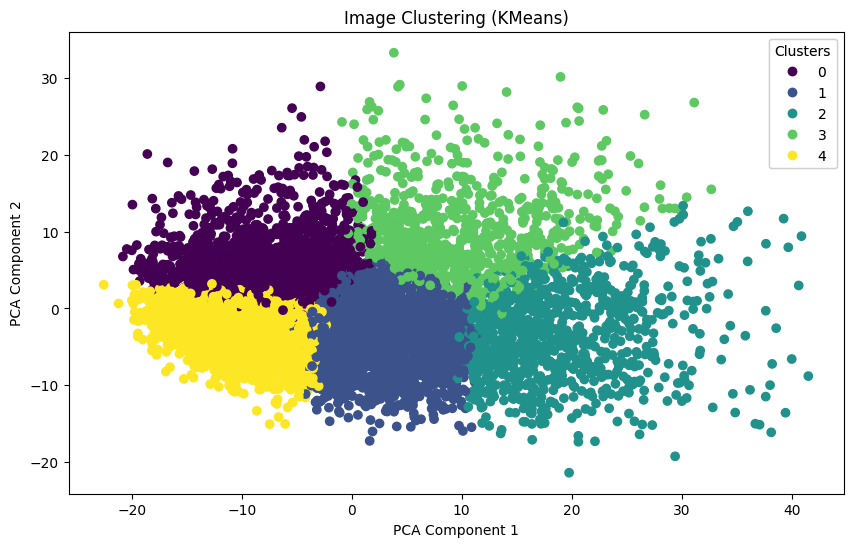

Cluster 0:
['主_NotoSerifJP.png', '交_NotoSerifJP.png', '亥_NotoSerifJP.png', '佘_NotoSerifJP.png', '余_NotoSerifJP.png', '佹_NotoSerifJP.png', '俊_NotoSerifJP.png', '倏_NotoSerifJP.png', '倓_NotoSerifJP.png', '偠_NotoSerifJP.png', '偽_NotoSerifJP.png', '傃_NotoSerifJP.png', '傍_NotoSerifJP.png', '傒_NotoSerifJP.png', '傘_NotoSerifJP.png', '傣_NotoSerifJP.png', '傻_NotoSerifJP.png', '僉_NotoSerifJP.png', '像_NotoSerifJP.png', '僕_NotoSerifJP.png', '僚_NotoSerifJP.png', '僾_NotoSerifJP.png', '儀_NotoSerifJP.png', '儉_NotoSerifJP.png', '儌_NotoSerifJP.png', '優_NotoSerifJP.png', '儳_NotoSerifJP.png', '儴_NotoSerifJP.png', '儵_NotoSerifJP.png', '充_NotoSerifJP.png', '兗_NotoSerifJP.png', '冀_NotoSerifJP.png', '冬_NotoSerifJP.png', '冼_NotoSerifJP.png', '凌_NotoSerifJP.png', '凜_NotoSerifJP.png', '凝_NotoSerifJP.png', '凳_NotoSerifJP.png', '刎_NotoSerifJP.png', '券_NotoSerifJP.png', '刻_NotoSerifJP.png', '剡_NotoSerifJP.png', '劇_NotoSerifJP.png', '劣_NotoSerifJP.png', '劦_NotoSerifJP.png', '努_NotoSerifJP.png', '劾_NotoSerifJP.png', '

In [17]:
# Load pre-trained ResNet model
model = models.resnet50(pretrained=True)
model.eval()

# Define image transformation (resize, normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to extract features using ResNet
def extract_features(image_path):
    img = Image.open(image_path).convert("L")
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        features = model(img_tensor)
    return features.flatten().numpy()

# Extract features for each image
image_features = []
image_names = []

for img_file in os.listdir(image_dir):
    if img_file.endswith(".png") and img_file != "Error.png":
        img_path = os.path.join(image_dir, img_file)
        features = extract_features(img_path)
        image_features.append(features)
        image_names.append(img_file)

# Convert the list of features into a NumPy array
image_features = np.array(image_features)

# Step 1: Clustering with KMeans
num_clusters = 5  # You can change the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(image_features)
labels = kmeans.labels_

# Step 2: Dimensionality Reduction (PCA or t-SNE) for visualization
# Using PCA to reduce features to 2D for plotting
pca = PCA(n_components=2)
pca_result = pca.fit_transform(image_features)

# Alternatively, you can use t-SNE for non-linear dimensionality reduction
# tsne = TSNE(n_components=2, random_state=42)
# tsne_result = tsne.fit_transform(image_features)

# Step 3: Plotting the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis')
plt.title('Image Clustering (KMeans)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Add a legend
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

# Display the plot
plt.show()

# Optional: Print out the clusters with the corresponding image names
for cluster_id in range(num_clusters):
    print(f"Cluster {cluster_id}:")
    cluster_images = [image_names[i] for i in range(len(labels)) if labels[i] == cluster_id]
    print(cluster_images)

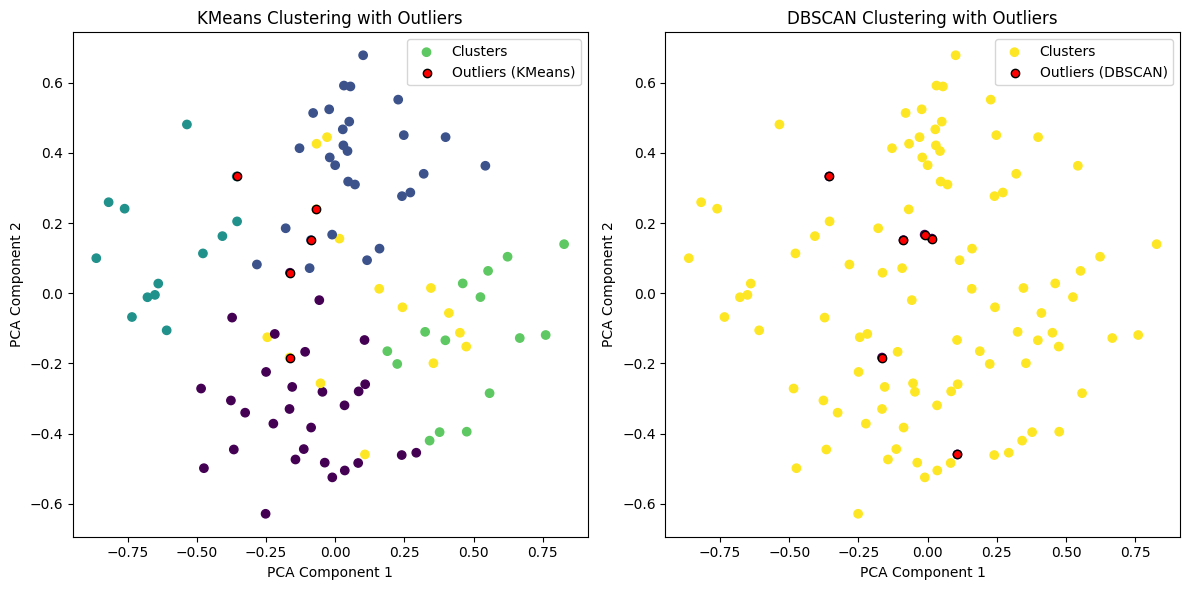

Displaying 5 KMeans outlier images:


FileNotFoundError: [Errno 2] No such file or directory: 'images\\image_8.png'

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from PIL import Image

# Sample image_vectors (replace with actual data from your images)
# Assuming image_vectors are stored as numpy arrays
np.random.seed(42)
image_vectors = np.random.rand(100, 5)  # Replace with actual image vectors

# Assuming each image corresponds to a file, you can have a list of image filenames or paths
image_filenames = [f"image_{i}.png" for i in range(100)]  # Replace this with your actual filenames

# Step 1: KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(image_vectors)

# Step 2: Calculate the distance of each point from its assigned cluster center
distances = np.linalg.norm(image_vectors - kmeans.cluster_centers_[kmeans.labels_], axis=1)

# Step 3: Define a threshold for outliers (e.g., 95th percentile of the distances)
threshold = np.percentile(distances, 95)
outliers_kmeans = distances > threshold

# Step 4: DBSCAN clustering (alternative method for detecting outliers)
db = DBSCAN(eps=0.5, min_samples=5)
labels_db = db.fit_predict(image_vectors)

# Mark points with label -1 as outliers in DBSCAN
outliers_dbscan = labels_db == -1

# Step 5: Reduce the dimensionality of image_vectors to 2D using PCA for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(image_vectors)

# Get 2D coordinates
x, y = reduced_data[:, 0], reduced_data[:, 1]

# Step 6: Plotting the KMeans clusters and outliers
plt.figure(figsize=(12, 6))

# KMeans clustering visualization
plt.subplot(1, 2, 1)
plt.scatter(x, y, c=kmeans.labels_, cmap='viridis', label="Clusters")
plt.scatter(x[outliers_kmeans], y[outliers_kmeans], color='red', label="Outliers (KMeans)", edgecolors='k')
plt.title("KMeans Clustering with Outliers")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()

# DBSCAN clustering visualization
plt.subplot(1, 2, 2)
plt.scatter(x, y, c=labels_db, cmap='viridis', label="Clusters")
plt.scatter(x[outliers_dbscan], y[outliers_dbscan], color='red', label="Outliers (DBSCAN)", edgecolors='k')
plt.title("DBSCAN Clustering with Outliers")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()

plt.tight_layout()
plt.show()

# Step 7: Show the images or details of outliers (for KMeans)
outlier_images_kmeans = [image_filenames[i] for i in range(len(outliers_kmeans)) if outliers_kmeans[i]]

# Display the images of the outliers
print(f"Displaying {len(outlier_images_kmeans)} KMeans outlier images:")
for img_file in outlier_images_kmeans:
    img_path = os.path.join('images', img_file)  # Adjust path as necessary
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Outlier Image: {img_file}")
    plt.axis('off')  # Hide axes
    plt.show()

# Optionally, show details about the outliers
for img_file in outlier_images_kmeans:
    print(f"Outlier Image: {img_file}")
